In [ ]:
!pip install opencv_python==4.5.4.60

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.3 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install idigbio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for idigbio: filename=idigbio-0.8.5-py2.py3-none-any.whl size=10118 sha256=8c8600d9f4000a30333ea704bc137272b1ef53dbc4ddcd9e79699386e4e80a29
  Stored in directory: /root/.cache/pip/wheels/da/b8/ea/5de907d647abd6aa547d9c0338dc1d82459c56cf019fec7f4c
Successfully built idigbio


In [ ]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Loading OpenCV package
import cv2
# Load idigbio package
import idigbio
# Load pandas package
import pandas
# Load requests package
import requests 

In [ ]:
# Specify that we want to return results as a dataframe
api = idigbio.pandas()


## Function that pull image from IdigBio like the last module.
def GetImageFromIdigBio():
  # Execute the search with a limit on retrieving only 1 results
  mediarecords = api.search_media(rq={'scientificname': 'Magnolia acuminata',
                                      'institutioncode':'CHRB',
                                    'hasImage': True}, limit = 1)
  # Pull UUID values out of the `mediarecords` dataframe and into a list data structure
  uuids = mediarecords.index.tolist()

  # Set standard URL prefix for files cached on the iDigBio server
  append_str = 'https://api.idigbio.org/v2/media/'

  # Define a URL suffix to specify we want to download the webview size images.
  # These are derivatives that iDigBio creates at 600px width + length adjusted
  # proportionally to whatever it needs to be to preserve the correct aspect ratio.
  # You can download higher resolution images by changing this string to '?size=fullsize'
  suffix_str = '?size=webview'

  # Create list of iDigBio media URLs by concatenating the prefix above with the
  # UUID values from `mediarecords`
  mediaurl_idigbio = [append_str + sub + suffix_str for sub in uuids]

  # Create list of external media URLs by pulling values for `accessuri` out of `mediarecords`
  mediaurl_external = mediarecords.accessuri.tolist()

    # Define what values we are iterating through
  image_url = mediaurl_idigbio[0]

  # Define a filename based on the UUID of the media record
  filename = 'TestImage' + '.jpg'

  # Begin the process of downloading a file
  r = requests.get(image_url, stream = True)

  # Check that the file can be retrieved successfully
  if r.status_code == 200:
      
      # Set this otherwise the downloaded image file size will be zero
      r.raw.decode_content = True

      # Open a local file
      with open(filename, 'wb') as file:
          for block in r.iter_content(chunk_size = 1024):
              if block: 
                  file.write(block) 
      
      # Report back on how things went
      print('Image sucessfully Downloaded: ',filename)
  else:
      print('Image Couldn\'t be retreived')

## Open CV Basics
Now that we have learn to successuflly download an image from the IdigBio API, and store it on our local machine we can get into the basics of how we can manipulate this image for our models. 

With Open CV all images are represented as 2d (grayscale images) and 3d (color images) arrays. As with most python libraries like pandas and scipy numpy arrays and python lists are at the core the object we are using to store our data.

So in that sense lets begin with some basic image operation

In [ ]:
import cv2
import numpy as np
## Special function for displaying image in jupyter Notebook
from google.colab.patches import cv2_imshow

Image sucessfully Downloaded:  TestImage.jpg
<class 'numpy.ndarray'>
(900, 600, 3)


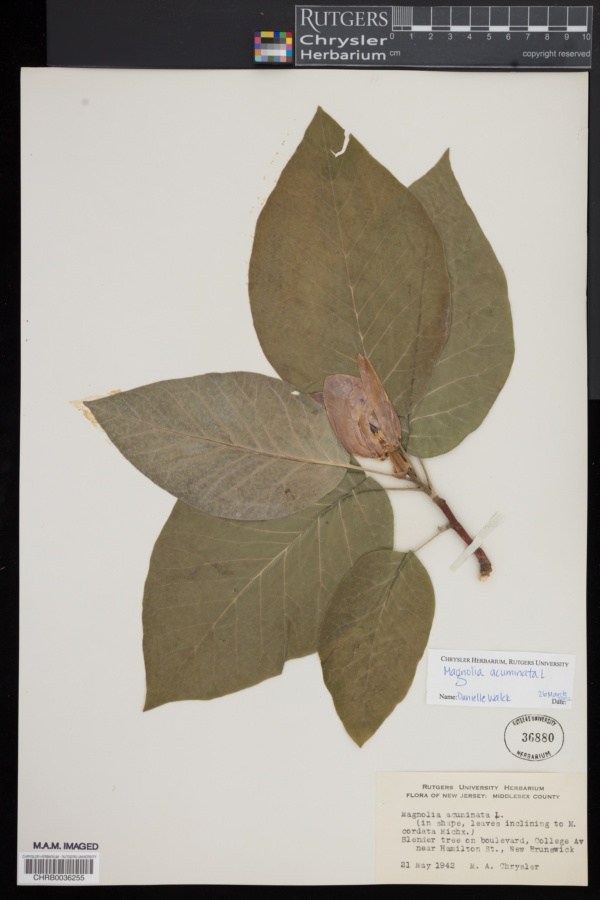

In [ ]:
## Importing our image with openCV, as a 3d numpy array
GetImageFromIdigBio()
img = cv2.imread('TestImage.jpg')
print(type(img))
print(img.shape)
cv2_imshow(img)

## A Quick Note on Color Spaces
OpenCV will by default import colored images in the RGB color space. Well, to be more accurate images are imported in the BGR format, so 
 - ```img[:,:,0] ``` is the blue channel
 - ```img[:,:,1] ``` is the green channel 
 - ```img[:,:,2] ``` is the red channel

In this color space each pixel is represented by a combination or red, green, blue intensities. This will become more important later on when we discuss thresholding. 

(900, 600, 3)


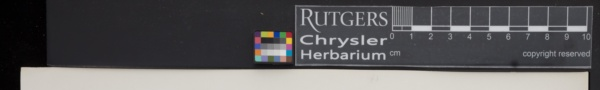

In [ ]:
## Image cropping can be achieved by using regular old python slice notation
print(np.shape(img))

## Cropping the Color Bar
colorBar = img[0:90,0:718,:]

## displaying the colorBar crop
cv2_imshow(colorBar)

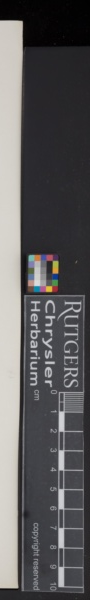

In [ ]:
## Using cv2.rotate to rotate the image
# Note that 'cv2.ROTATE_90_CLOCKWISE' can be replaced with single digit flag found in open CV documentation
# https://docs.opencv.org/3.4/d2/de8/group__core__array.html
rotatedcolorBar = cv2.rotate(colorBar, cv2.ROTATE_90_CLOCKWISE)
# rotatedcolorBar = cv2.rotate(colorBar, 0)
cv2_imshow(rotatedcolorBar)

(90, 600)


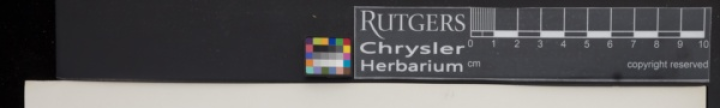

In [ ]:
## Using cv2.resize() to resize the image
# Resizing and PRESERVING ASPECT RATIO
print((colorBar.shape[0],colorBar.shape[1]))
# By Percentage

scalePercent = 120
dim = (int(colorBar.shape[1]*scalePercent/100),int(colorBar.shape[0]*scalePercent/100))
resized = cv2.resize(colorBar, dim, interpolation = cv2.INTER_AREA)
cv2_imshow(resized)

# By Factor
# scaleFactor = 1.2
# dim = (int(colorBar.shape[1]*scaleFactor),int(colorBar.shape[0]*scaleFactor))
# resized = cv2.resize(colorBar, dim, interpolation = cv2.INTER_AREA)
# cv2_imshow(resized)

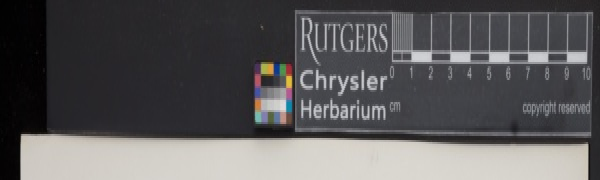

In [ ]:
## Using cv2.resize() to resize the image
# Resizing WITHOUT PRESERVING ASPECT RATIO
dim = colorBar.shape
resized = cv2.resize(colorBar,(dim[1],dim[0]*2), interpolation = cv2.INTER_AREA)
cv2_imshow(resized)
## Works with any target dimension

## Filters, Thresholding, and Building Segmentation Masks
In the following example we will generate a segmentation mask for the test image we downloaded before. We will cover how we can apply filters to remove noise image, different methods for thresholding, mask operations, and contour/bounding box detection.

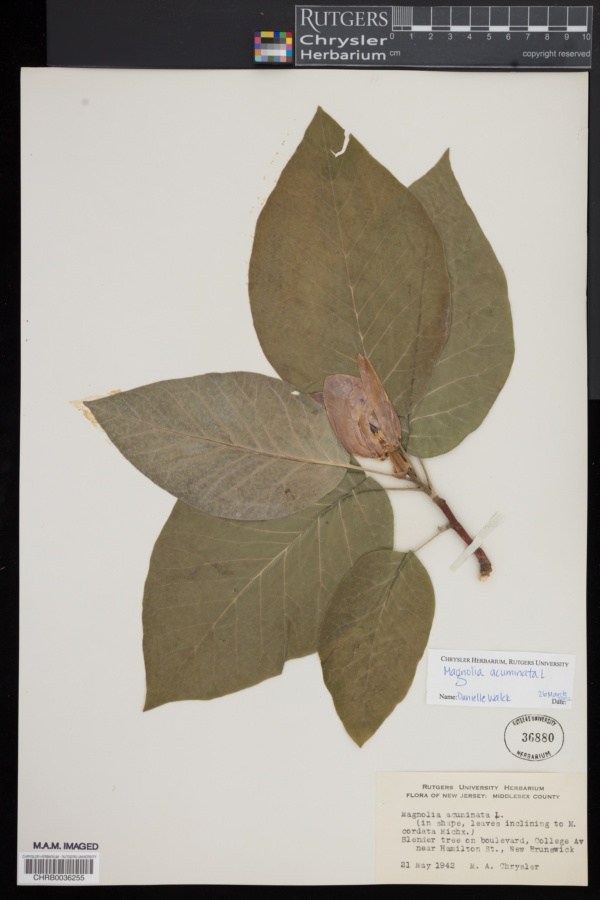

In [ ]:
cv2_imshow(img)

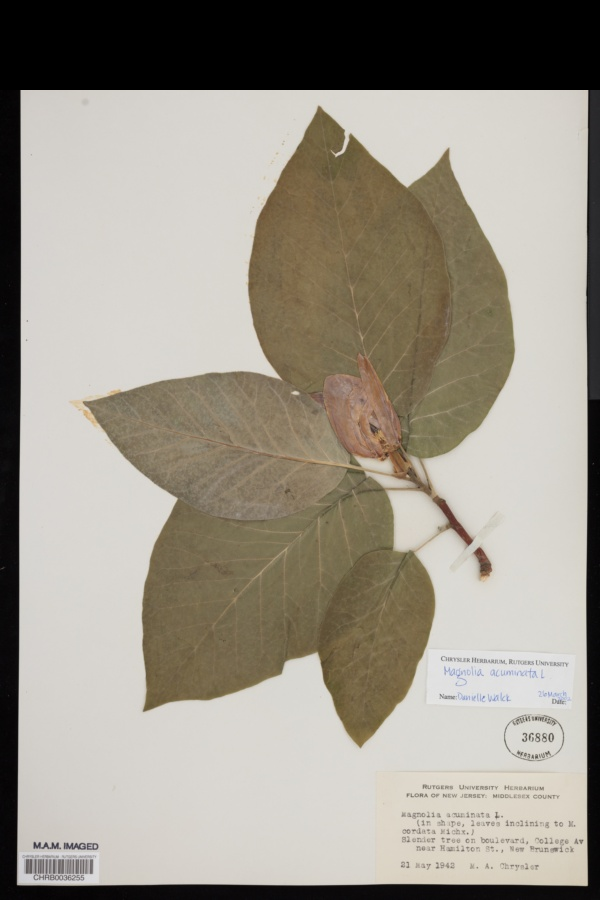

In [ ]:
## Removing the color bar. For batches of sheets from the same institution this can be a valid method for 
## systematically removing the color bar.
img[0:90,0:718,:] = (0,0,0) # assigning color bar slice to black
cv2_imshow(img)

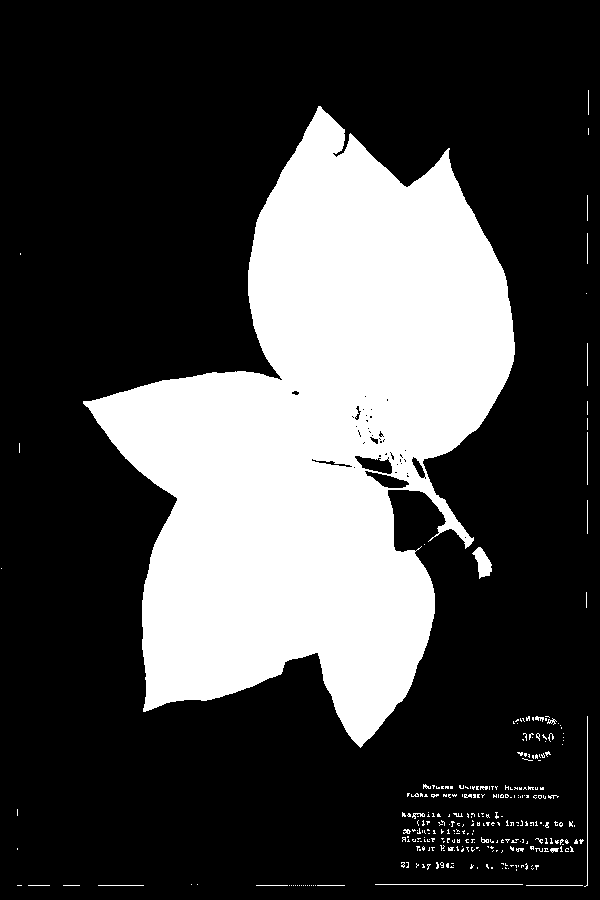

In [ ]:
## The plant is greenish against a usually controlled white background, 
## so an initial color threshold will help us identify where the plant is in the image
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
HSV_Threshold = cv2.inRange(img_HSV, (0, 20, 50), (30, 150, 180)) ## HSV Range for approximatly the color of the plant
cv2_imshow(HSV_Threshold)

In [ ]:
## Another method we can apply which works decently well, since the background is very white and 
## the forground is a darker green earthy color is binary threholding
img_GRAY = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
otsu_threshold, GRAY_Threshold = cv2.threshold(img_GRAY, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
cv2_imshow(GRAY_Threshold)

## Here we seem to accepting the dark pixels that border the Herbarium Sheet. For some samples Binary Threholding might be ideal.

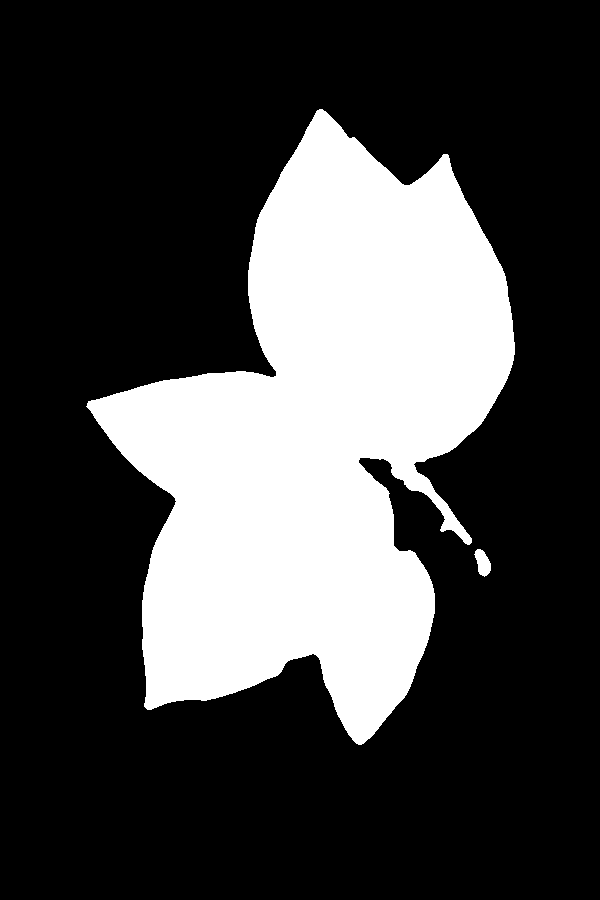

In [ ]:
## For now let's continue with the HSV color threshold for trying to identify where in the image the plant is. 
## Recall that the image is accepting much of the text and small artifacts around the border of the sheet. 
## We will attempt to remove that noise by using a filter. 
HSV_Threshold = cv2.medianBlur(HSV_Threshold, ksize=11)
cv2_imshow(HSV_Threshold)

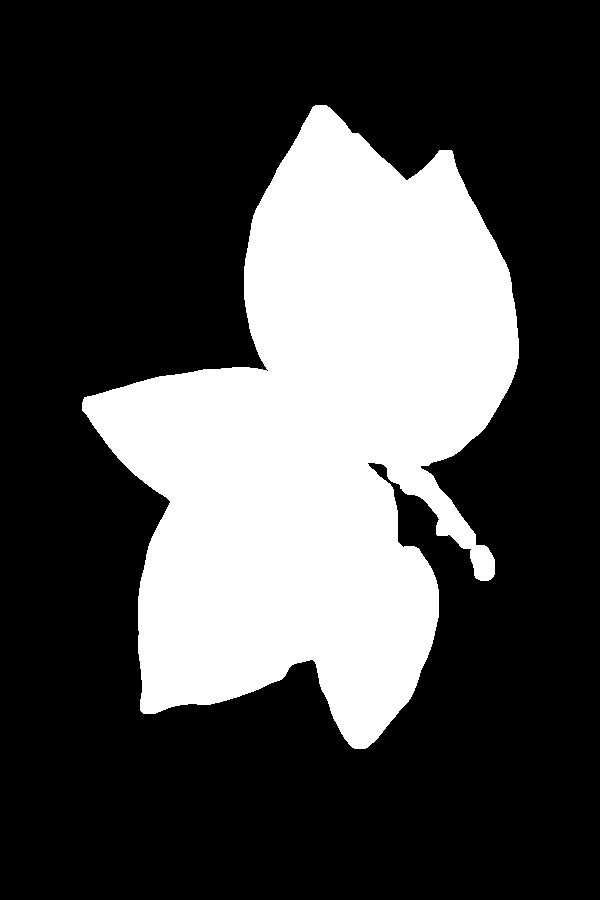

In [ ]:
## With a single filter we've managed to remove the text, but we've lost a lot of the detail in the edges of the plant
## Luckily our new mask can be used to localize the plant on the image, and we can threshold again to get the detail back. 

# Taking a matrix of size 5 as the kernel
kernel = np.ones((5,5), np.uint8)
# Apply dilation to inital mask for border
PlantMask = cv2.dilate(HSV_Threshold, kernel, iterations=2)
cv2_imshow(PlantMask)

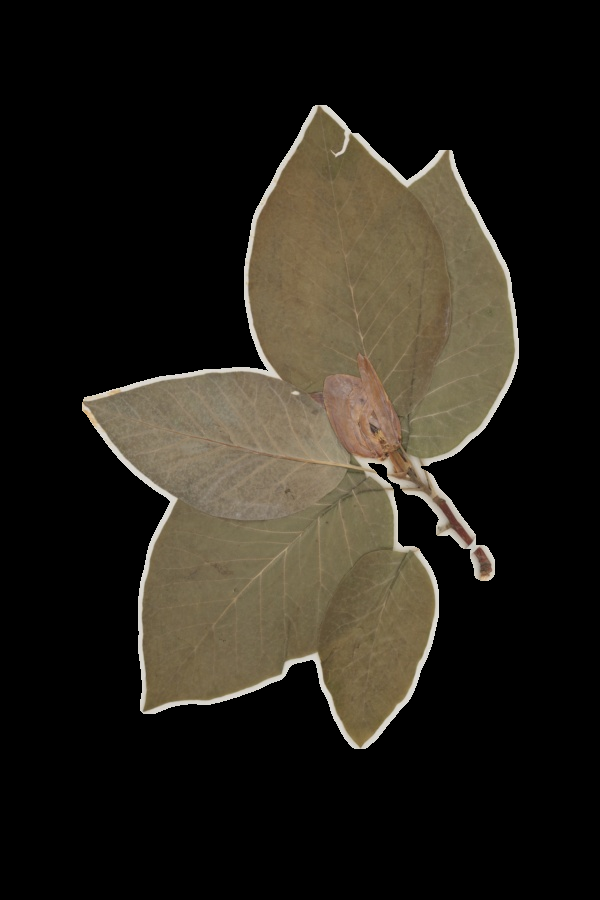

In [ ]:
## Re-Crop the inital image from mask
PlantMask=cv2.cvtColor(PlantMask,cv2.COLOR_GRAY2BGR)#change mask to a 3 channel image 
PreProcess=cv2.subtract(PlantMask,img)
PreProcess=cv2.subtract(PlantMask,PreProcess)
cv2_imshow(PreProcess)

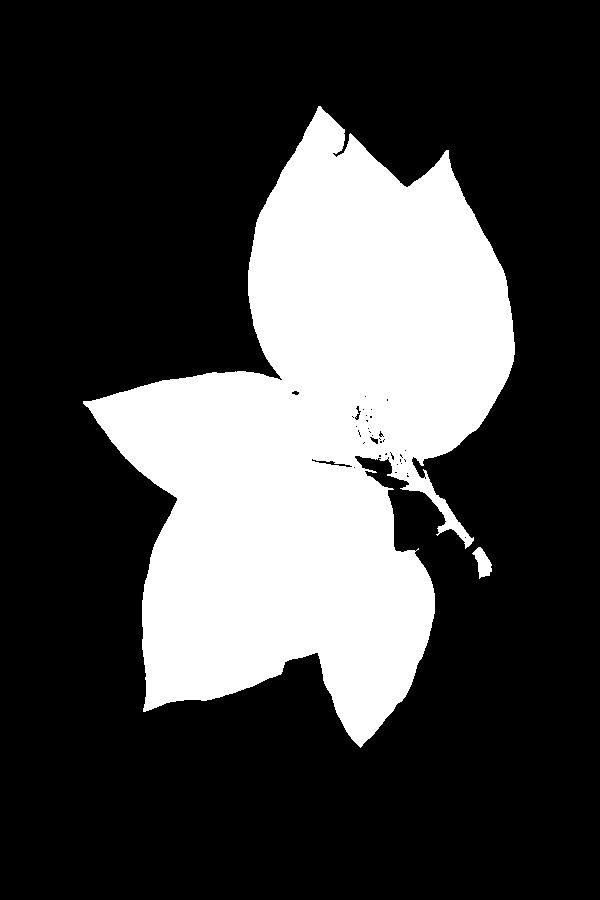

In [ ]:
## Rethresholding we get the final segmentation mask
## With HSV
PreProcess_HSV = cv2.cvtColor(PreProcess, cv2.COLOR_BGR2HSV)
HSV_Threshold = cv2.inRange(PreProcess_HSV, (0, 20, 50), (30, 150, 180)) ## HSV Range for approximatly the color of the plant
cv2_imshow(HSV_Threshold)